# Monte Carlo Default Simulation

We aim to estimate the expected loss up to time T:

$$E[L_T] = E\left[\sum_{i=1}^{N} \ell_i \cdot 1\{T_i \leq T\}\right]$$

Where:

- $\ell_i$ represents the loss amount from default $i$
- $T_i$ represents the default time for firm $i$
- $1\{T_i \leq T\}$ is the indicator function for defaults occurring before time $T$

## Model Components

### Firm Intensity Process
Each firm's default intensity is modeled as:

$$\lambda_t^i = X_i + \sum_{j=1}^{J} w_{ij} Y_t^j$$

Where:
- $X_i$ is the idiosyncratic component for firm $i$
- $Y_t^j$ is the sectoral intensity component
- $w_{ij}$ are loading factors representing sensitivity to sectoral factors

### Sectoral Intensity Dynamics with Contagion
Each sector follows a process with mean reversion, volatility, and contagion effects:

$$dY_t^j = \kappa_j(\theta_j - Y_t^j)dt + \sqrt{Y_t^j}\sum_{k=1}^{J}\sigma_{jk}dW_t^k + \sum_{k=1}^{J}\delta_{jk}dL_t^k$$

Where:
- $\kappa_j$ is the mean reversion speed
- $\theta_j$ is the long-term mean level
- $\sigma_{jk}$ are volatility parameters
- $W_t^k$ are standard Brownian motions
- $\delta_{jk}$ are contagion coefficients
- $L_t^k$ are loss processes for each sector


## In this notebook we attempt to use the Jump Approximation Methods as discussed in *Reducing Bias in Event Time Simulations via Measure Changes (Giesecke, Shkolnik (2018))*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

RNG = np.random.default_rng(42)

In [16]:
def draw_params(N=100, J=5):

    X = RNG.uniform(0.01, 0.05, size=N)                      # idio intensities

    w0 = RNG.uniform(0,1,(N,J))
    W = w0 / w0.sum(axis=1, keepdims=True)                   # exposures

    ell = np.ones(N)                                         # LGD
    
    kappa = RNG.uniform(0.5,1.5,size=J)
    theta = RNG.uniform(0.05,0.25,size=J)
    
    sigma = np.zeros((J,J))
    for j in range(J):
        s = RNG.uniform(0.1,0.2)
        sigma[j,j] = min(s, np.sqrt(2*kappa[j]*theta[j])) # enforce feller condn 
    
    sigma[sigma==0] = 0.05                                   # off-diag
    
    delta = RNG.uniform(0,0.1,(J,J))
    
    # Brownian corr matrix
    rho = 0.3
    Corr = np.eye(J)*1 + (1-np.eye(J))*rho
    
    return dict(N=N, J=J, X=X, W=W, ell=ell,
                kappa=kappa, theta=theta, sigma=sigma, delta=delta,
                Corr=Corr)


In [17]:
params = draw_params()
print(params)

{'N': 100, 'J': 5, 'X': array([0.03957726, 0.04203486, 0.01195855, 0.01938141, 0.03487591,
       0.04432501, 0.01018   , 0.03058517, 0.0370915 , 0.01118429,
       0.02605422, 0.0458254 , 0.03686451, 0.01950633, 0.04411125,
       0.02392126, 0.04413379, 0.02195775, 0.03361281, 0.0258776 ,
       0.020993  , 0.0454623 , 0.01750375, 0.01339246, 0.02367708,
       0.03870557, 0.04229726, 0.04994973, 0.02185448, 0.02631768,
       0.01547285, 0.03299488, 0.0499032 , 0.03803524, 0.03380851,
       0.02569476, 0.04661195, 0.02987666, 0.01537468, 0.02461514,
       0.01268667, 0.01807916, 0.01070675, 0.0281312 , 0.03538161,
       0.0237317 , 0.02681527, 0.04836837, 0.04007852, 0.03163427,
       0.02138164, 0.04587987, 0.01940388, 0.02301371, 0.04636259,
       0.03118168, 0.03969272, 0.03362979, 0.03613757, 0.02197533,
       0.01965488, 0.02289969, 0.01621766, 0.04497257, 0.02132988,
       0.03245958, 0.04167898, 0.04135296, 0.02753545, 0.02905029,
       0.04978807, 0.0369839 , 0.04258

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from numba import jit, prange
from numba.core import types
from numba.typed import Dict
import pandas as pd


def draw_params(N=100, J=5, seed=42):
    rng = np.random.default_rng(seed)

    X = rng.uniform(0.01, 0.05, size=N)  # Idiosyncratic intensities
    
    
    w0 = rng.uniform(0, 1, (N, J))
    W = w0 / w0.sum(axis=1, keepdims=True)

    ell = np.ones(N)  # lgd
    
    kappa = rng.uniform(0.5, 1.5, size=J)
    theta = rng.uniform(0.05, 0.25, size=J)
    
    # volatility matrix with feller condition enforced
    sigma = np.zeros((J, J))
    for j in range(J):
        s = rng.uniform(0.1, 0.2)
        sigma[j, j] = min(s, np.sqrt(2 * kappa[j] * theta[j]))
    
    sigma[sigma == 0] = 0.05  # off-diagonal 
    
    delta = rng.uniform(0, 0.1, (J, J))  # contagion 
    
    # brownian corr matrix
    rho = 0.3
    Corr = np.eye(J) * (1 - rho) + rho
    
    return dict(N=N, J=J, X=X, W=W, ell=ell,
                kappa=kappa, theta=theta, sigma=sigma, delta=delta,
                Corr=Corr)

@jit(nopython=True, cache=True)
def _calculate_intensities(Y, X, w, alive_mask):
    """Helper function to compute firm intensities."""
    h = X + Y @ w.T
    h[~alive_mask] = 0.0  # set intensities of defaulted firms to zero
    return np.maximum(h, 0.0)

@jit(nopython=True, cache=True)
def simulate_plainjam_path(
    X,                          # Idiosyncratic intensities [N]
    w,                          # Firm-sector weights [N, J]  
    losses,                     # Loss sizes per firm [N]
    kappa,                      # Mean-reversion speed [J]
    theta,                      # Long-term mean [J]
    sigma,                      # Volatility matrix [J, J]
    delta,                      # Contagion jumps [J, J]
    L_chol,                     # Cholesky decomp of Brownian correlation [J, J]
    Y_init,                     # Initial sector state [J]
    T,                          # Time horizon
    dt_max,                     # Max substep size for SDE integration
    seed                        # reproducibility seed
):
    np.random.seed(seed)
    
    t = 0.0
    Y = Y_init.copy()
    N, J = w.shape
    alive_mask = np.ones(N, dtype=np.bool_)
    total_loss = 0.0
    log_L = 0.0  # Radon-Nikodym derivative ie likelihood adjustment

    # pre-calculate the primary sector for each firm for contagion (a representative of sorts)
    firm_sectors = np.argmax(w, axis=1)
    
    eps = 1e-12 

    while t < T:
        if not np.any(alive_mask):
            break

        # freeze intensities under the Q-measure
        # we need the counting process to be a step fucntion under the Q-measure
        # TODO: are we sure this way is correct?
        h_Q = _calculate_intensities(Y, X, w, alive_mask)
        lambda_hat = h_Q.sum()
        
        if lambda_hat < eps:
            break
            
        # next event time
        eta = -np.log(np.random.uniform()) / lambda_hat
        t_next = t + eta
        
        if t_next > T:
            break
            
        # evolve state
        m = int(np.ceil(eta / dt_max))
        dt = eta / m
        
        R_integral = 0.0
        h_P_prev = h_Q.copy()

        for _ in range(m):
            # intensities evolution using Euler-Maruyama
            z = np.random.standard_normal(J)
            dW = (L_chol @ z) * np.sqrt(dt)
            
            Y_sqrt = np.sqrt(np.maximum(Y, 0.0))
            drift = kappa * (theta - Y) * dt

            diffusion = np.zeros(J)
            for j in range(J):
                diffusion[j] = Y_sqrt[j] * np.dot(sigma[j, :], dW)
            
            Y = np.maximum(Y + drift + diffusion, 0.0) # no jump part needed here, accounted for by Q
            
            h_P_curr = _calculate_intensities(Y, X, w, alive_mask)
            R_integral += 0.5 * dt * (h_P_curr + h_P_prev).sum()
            h_P_prev = h_P_curr

        
        r_ell = h_P_prev.sum() 
        if r_ell > eps:
            log_L += np.log(lambda_hat / r_ell) - lambda_hat * eta + R_integral
        
        # sample which firm defaults
        probs = h_P_prev / r_ell 
        firm_idx = np.searchsorted(np.cumsum(probs), np.random.uniform())
        
        # now we apply contagion jump
        defaulting_sector = firm_sectors[firm_idx]
        Y += delta[:, defaulting_sector] * losses[firm_idx]

        total_loss += losses[firm_idx]
        alive_mask[firm_idx] = False
        t = t_next

    weight = np.exp(min(max(log_L, -50.0), 50.0))
    
    return total_loss, weight

@jit(nopython=True, parallel=True, cache=True)
def run_simulation(
    n_paths, T, dt_max, base_seed,
    X, w, losses, kappa, theta, sigma, delta, L_chol, Y_init
):
    """Runs the plain JAM simulation in parallel."""
    results_loss = np.zeros(n_paths)
    results_weight = np.zeros(n_paths)
    
    for i in prange(n_paths):
        seed = base_seed + i*65535
        loss, weight = simulate_plainjam_path(
            X, w, losses, kappa, theta, sigma, delta, L_chol, Y_init,
            T, dt_max, seed
        )
        results_loss[i] = loss
        results_weight[i] = weight
    
    return results_loss, results_weight

In [22]:
class MonteCarloSimulator:
    
    def __init__(self, params):
        self.params = params
        self.N = params['N']
        self.J = params['J']
        
        self.X = np.asarray(params['X'], dtype=np.float64)
        self.w = np.asarray(params['W'], dtype=np.float64)
        self.losses = np.asarray(params['ell'], dtype=np.float64)
        self.kappa = np.asarray(params['kappa'], dtype=np.float64)
        self.theta = np.asarray(params['theta'], dtype=np.float64)
        self.sigma = np.asarray(params['sigma'], dtype=np.float64)
        self.delta = np.asarray(params['delta'], dtype=np.float64)
        
        
        try:
            self.L_chol = cholesky(params['Corr'], lower=True).astype(np.float64)
        except np.linalg.LinAlgError:
            print("Warning: Correlation matrix not positive definite, using identity")
            self.L_chol = np.eye(self.J, dtype=np.float64)
    
    def run_simulation(self, n_paths=1000, T=1.0, dt_max=0.01, base_seed=42):

        # Start at long-term mean
        Y_init = self.theta.copy()
        
        print(f"Running {n_paths} simulations")
        
        
        losses, weights = run_simulation(
            n_paths, T, dt_max, base_seed,
            self.X, self.w, self.losses, self.kappa, self.theta, 
            self.sigma, self.delta, self.L_chol, Y_init
        )
        
        # Compute weighted statistics
        total_weight = np.sum(weights)
        if total_weight > 0:
            expected_loss = np.sum(losses * weights) / total_weight
            
            variance = np.sum(weights * (losses - expected_loss)**2) / total_weight
            std_error = np.sqrt(variance / n_paths)
            effective_sample_size = total_weight**2 / np.sum(weights**2)
        else:
            expected_loss = np.mean(losses)
            std_error = np.std(losses) / np.sqrt(n_paths)
            variance = np.var(losses)
            effective_sample_size = n_paths
        
        return {
            'expected_loss': expected_loss,
            'std_error': std_error,
            'variance': variance,
            'losses': losses,
            'weights': weights,
            'n_paths': n_paths,
            'effective_sample_size': effective_sample_size
        }
    
    def plot_results(self, results):
        """Plot simulation results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        losses = results['losses']
        weights = results['weights']
        
        # Loss distribution
        ax1.hist(losses, bins=50, alpha=0.7, density=True)
        ax1.axvline(results['expected_loss'], color='red', linestyle='--', 
                   label=f'E[L] = {results["expected_loss"]:.3f}')
        ax1.set_xlabel('Total Loss')
        ax1.set_ylabel('Density')
        ax1.set_title('Loss Distribution')
        ax1.legend()
        
        # Weight distribution
        positive_weights = weights[weights > 0]
        if len(positive_weights) > 0:
            ax2.hist(positive_weights, bins=50, alpha=0.7)
            ax2.set_xlabel('Importance Weight')
            ax2.set_ylabel('Frequency')
            ax2.set_title('Weight Distribution')
            ax2.set_yscale('log')
        
        # Loss vs Weight scatter
        positive_mask = weights > 0
        if np.any(positive_mask):
            ax3.scatter(losses[positive_mask], weights[positive_mask], alpha=0.6, s=1)
            ax3.set_xlabel('Total Loss')
            ax3.set_ylabel('Weight')
            ax3.set_title('Loss vs Weight')
            ax3.set_yscale('log')
        
        # Convergence plot
        cumulative_weighted_loss = np.cumsum(losses * weights)
        cumulative_weights = np.cumsum(weights)
        valid_idx = cumulative_weights > 0
        if np.any(valid_idx):
            running_mean = np.zeros_like(cumulative_weighted_loss)
            running_mean[valid_idx] = cumulative_weighted_loss[valid_idx] / cumulative_weights[valid_idx]
            
            ax4.plot(running_mean)
            ax4.axhline(results['expected_loss'], color='red', linestyle='--')
            ax4.set_xlabel('# Paths')
            ax4.set_ylabel('Running Expected Loss')
            ax4.set_title('Convergence')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nSimulation Results:")
        print(f"Expected Loss: {results['expected_loss']:.6f}")
        print(f"Standard Error: {results['std_error']:.6f}")
        print(f"95% CI: [{results['expected_loss'] - 1.96*results['std_error']:.6f}, "
              f"{results['expected_loss'] + 1.96*results['std_error']:.6f}]")
        print(f"Effective Sample Size: {results['effective_sample_size']:.1f}")
        
        valid_weights = weights[weights > 0]
        if len(valid_weights) > 0:
            print(f"Weight Statistics: min={np.min(valid_weights):.2e}, max={np.max(valid_weights):.2e}, "
                  f"mean={np.mean(valid_weights):.2e}")
        # print(f"Zero weights: {np.sum(weights == 0)} / {len(weights)}")

    def plot_sample_intensity_paths(self, T=1.0, dt_max=0.001, n_paths=5, seed=42):

        # tjis is to plot sample intensity paths under both measures for a visual confirmation of correctness of implementation
        np.random.seed(seed)
        
        fig = go.Figure()
        N, J = self.w.shape

        for path in range(n_paths):
            times = [0.0]
            sum_hQ_list = []
            sum_hP_list = []
            jump_times = []

            Y = self.theta.copy()
            t = 0.0
            alive = np.ones(N, dtype=bool)

            while t < T:
                alive_idx = np.where(alive)[0]
                if len(alive_idx) == 0:
                    break

                
                hQ = np.array([max(self.X[i] + np.dot(self.w[i], Y), 0.0) for i in alive_idx])
                lambda_hat = np.sum(hQ)
                if lambda_hat < 1e-12:
                    break

                eta = -np.log(np.random.rand()) / lambda_hat
                S = t + eta
                if S > T:
                    break

                m = int(np.ceil(eta / dt_max))
                dt = eta / m
                times_segment = np.linspace(t, S, m + 1)[1:]

                sum_hQ_list.extend([lambda_hat] * m)

                hP_vals = []
                for _ in range(m):
                    dW = self.L_chol @ np.random.randn(J) * np.sqrt(dt)
                    for j in range(J):
                        y = max(Y[j], 0.0)
                        drift = self.kappa[j] * (self.theta[j] - y) * dt
                        diffusion = np.sqrt(y) * np.sum(self.sigma[j, :] * dW)
                        Y[j] = max(Y[j] + drift + diffusion, 0.0)
                    lambda_p = np.sum([max(self.X[i] + np.dot(self.w[i], Y), 0.0) for i in alive_idx])
                    hP_vals.append(lambda_p)

                times.extend(times_segment)
                sum_hP_list.extend(hP_vals)
                jump_times.append(S)

                probs = hQ / lambda_hat
                i_rel = np.searchsorted(np.cumsum(probs), np.random.rand())
                firm = alive_idx[min(i_rel, len(alive_idx) - 1)]
                sector_k = np.argmax(self.w[firm])
                Y += self.delta[:, sector_k]
                Y = np.maximum(Y, 0.0)
                alive[firm] = False
                t = S

            times = np.array(times[:len(sum_hP_list)]) 

            fig.add_trace(go.Scatter(
                x=times, y=sum_hP_list,
                mode='lines',
                name=f'P-intensity {path+1}',
                line=dict(dash='dot'),
                opacity=0.9
            ))

            fig.add_trace(go.Scatter(
                x=times, y=sum_hQ_list,
                mode='lines',
                name=f'Q-intensity {path+1}',
                line=dict(width=2),
                opacity=0.5
            ))

            fig.add_trace(go.Scatter(
                x=jump_times,
                y=[max(sum_hP_list[min(len(sum_hP_list)-1, int(t/T * len(sum_hP_list)))], 1e-2) for t in jump_times],
                mode='markers',
                name=f'Jumps {path+1}',
                marker=dict(symbol='x', size=6),
                showlegend=False
            ))

        fig.update_layout(
            title='Q vs P Intensity Sample Paths (Plain JAM)',
            xaxis_title='Time',
            yaxis_title='Total Intensity',
            hovermode='closest',
            template='plotly_white',
            legend=dict(itemsizing='constant')
        )

        fig.show()

Running 50000 simulations


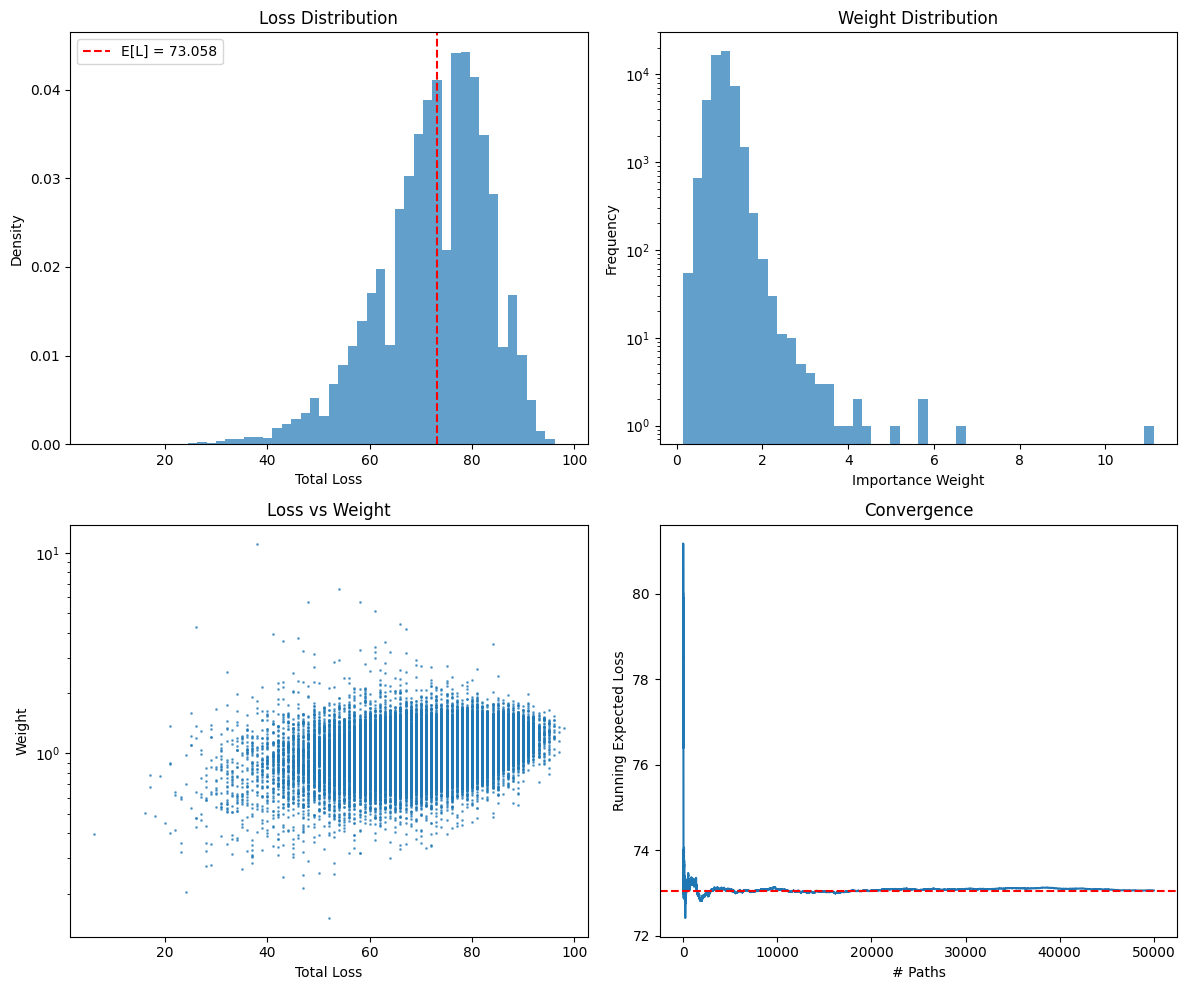


Simulation Results:
Expected Loss: 73.058079
Standard Error: 0.046794
95% CI: [72.966363, 73.149796]
Effective Sample Size: 47627.2
Weight Statistics: min=1.51e-01, max=1.11e+01, mean=1.06e+00


In [24]:
params = draw_params(N=100, J=3, seed=42)
simulator = MonteCarloSimulator(params)

results = simulator.run_simulation(n_paths=50000, T=1.0, dt_max=0.001, base_seed=42)
simulator.plot_results(results)
simulator.plot_sample_intensity_paths(T=0.5, dt_max=0.001, n_paths=1, seed=42)

## Model Components

### Firm Intensity Process
Each firm's default intensity is modeled as:

$$\lambda_t^i = X_i + \sum_{j=1}^{J} w_{ij} Y_t^j$$

Where:
- $X_i$ is the idiosyncratic component for firm $i$
- $Y_t^j$ is the sectoral intensity component
- $w_{ij}$ are loading factors representing sensitivity to sectoral factors

### Sectoral Intensity 

**We assume orthogonal sectors.**
Each sector follows a process with mean reversion, volatility, and **with 

$$dY_t^j = \kappa_j(\theta_j - Y_t^j)dt + \sigma_{j}\sqrt{Y_t^j}dW_t^j + \sum_{i=1}^{N}\delta_{ij}dL_t^i$$

Where:
- $\kappa_j$ is the mean reversion speed
- $\theta_j$ is the long-term mean level
- $\sigma_{j}$ are volatility parameters
- $W_t^j$ are standard Brownian motions
- $\delta_{ij}$ are contagion coefficients
- $L_t$ is the global loss process for all sectors

**We also take $\delta_{ij} = w_{ij}$ for now.**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from numba import jit, prange


def draw_params(N=100, J=5, seed=42):
    rng = np.random.default_rng(seed)

    X = rng.uniform(0.001, 0.01, size=N) 

    w0 = rng.uniform(0, 1, (N, J))
    W = w0 / w0.sum(axis=1, keepdims=True)

    ell = np.ones(N)  
    
    kappa = rng.uniform(1.0, 2.0, size=J)  
    theta = rng.uniform(0.01, 0.05, size=J)  
    
    # Diagonal volatility parameters (orthogonal sectors)
    sigma = np.zeros(J)
    for j in range(J):
        s = rng.uniform(0.05, 0.1)  
        
        sigma[j] = min(s, np.sqrt(2 * kappa[j] * theta[j]))
    
    # NOTE: No separate delta matrix needed - we use W directly for contagion
    # When firm i defaults: Y_j += w_ij * ell_i for all j
    
    # brownian corr matrix 
    rho = 0.0  # orthogonal sectors
    Corr = np.eye(J) * (1 - rho) + rho
    
    return dict(N=N, J=J, X=X, W=W, ell=ell,
                kappa=kappa, theta=theta, sigma=sigma,
                Corr=Corr)

@jit(nopython=True, cache=True)
def _calculate_intensities(Y, X, w, alive_mask):
    """Helper function to compute firm intensities."""
    h = X + Y @ w.T
    h[~alive_mask] = 0.0  # set intensities of defaulted firms to zero
    return np.maximum(h, 0.0)

@jit(nopython=True, cache=True)
def simulate_plainjam_path(
    X,                          # Idiosyncratic intensities [N]
    w,                          # Firm-sector weights [N, J]  
    losses,                     # Loss sizes per firm [N]
    kappa,                      # Mean-reversion speed [J]
    theta,                      # Long-term mean [J]
    sigma,                      # Volatility parameters [J] (diagonal)
    L_chol,                     # Cholesky decomp - identity for orthogonal
    Y_init,                     # Initial sector state [J]
    T,                          # Time horizon
    dt_max,                     # Max substep size for SDE integration
    seed                        # reproducibility seed
):
    np.random.seed(seed)
    
    t = 0.0
    Y = Y_init.copy()
    N, J = w.shape
    alive_mask = np.ones(N, dtype=np.bool_)
    total_loss = 0.0
    log_L = 0.0  
    eps = 1e-12 

    while t < T:
        if not np.any(alive_mask):
            break

        h_Q = _calculate_intensities(Y, X, w, alive_mask)
        lambda_hat = h_Q.sum()
        
        if lambda_hat < eps:
            break

        eta = -np.log(np.random.uniform()) / lambda_hat
        t_next = t + eta
        
        if t_next > T:
            break

        m = int(np.ceil(eta / dt_max))
        dt = eta / m
        
        R_integral = 0.0
        h_P_prev = h_Q.copy()

        for _ in range(m):
            z = np.random.standard_normal(J)
            dW = (L_chol @ z) * np.sqrt(dt)  

            Y_sqrt = np.sqrt(np.maximum(Y, 0.0))
            drift = kappa * (theta - Y) * dt

            diffusion = sigma * Y_sqrt * dW
            
            Y = np.maximum(Y + drift + diffusion, 0.0)

            h_P_curr = _calculate_intensities(Y, X, w, alive_mask)
            R_integral += 0.5 * dt * (h_P_curr + h_P_prev).sum()
            h_P_prev = h_P_curr

        r_ell = h_P_prev.sum() 
        if r_ell > eps:
            log_L += np.log(lambda_hat / r_ell) - lambda_hat * eta + R_integral

        probs = h_P_prev / r_ell 
        firm_idx = np.searchsorted(np.cumsum(probs), np.random.uniform())
        
        # Each sector j gets a jump proportional to the defaulting firm's weight w_ij
        Y += w[firm_idx, :] * losses[firm_idx]

        total_loss += losses[firm_idx]
        alive_mask[firm_idx] = False
        t = t_next

    weight = np.exp(min(max(log_L, -50.0), 50.0))
    
    return total_loss, weight

@jit(nopython=True, parallel=True, cache=True)
def run_simulation(
    n_paths, T, dt_max, base_seed,
    X, w, losses, kappa, theta, sigma, L_chol, Y_init
):
    results_loss = np.zeros(n_paths)
    results_weight = np.zeros(n_paths)
    
    for i in prange(n_paths):
        seed = base_seed + i*65535
        loss, weight = simulate_plainjam_path(
            X, w, losses, kappa, theta, sigma, L_chol, Y_init,
            T, dt_max, seed
        )
        results_loss[i] = loss
        results_weight[i] = weight
    
    return results_loss, results_weight

In [6]:
class MonteCarloSimulator:
    
    def __init__(self, params):
        self.params = params
        self.N = params['N']
        self.J = params['J']
        
        self.X = np.asarray(params['X'], dtype=np.float64)
        self.w = np.asarray(params['W'], dtype=np.float64)
        self.losses = np.asarray(params['ell'], dtype=np.float64)
        self.kappa = np.asarray(params['kappa'], dtype=np.float64)
        self.theta = np.asarray(params['theta'], dtype=np.float64)
        self.sigma = np.asarray(params['sigma'], dtype=np.float64)
        # self.delta = np.asarray(params['delta'], dtype=np.float64)
        
        
        try:
            self.L_chol = cholesky(params['Corr'], lower=True).astype(np.float64)
        except np.linalg.LinAlgError:
            print("Warning: Correlation matrix not positive definite, using identity")
            self.L_chol = np.eye(self.J, dtype=np.float64)
    
    def run_simulation(self, n_paths=1000, T=1.0, dt_max=0.01, base_seed=42):

        # Start at long-term mean
        Y_init = self.theta.copy()
        
        print(f"Running {n_paths} simulations")
        
        
        losses, weights = run_simulation(
            n_paths, T, dt_max, base_seed,
            self.X, self.w, self.losses, self.kappa, self.theta, 
            self.sigma, self.L_chol, Y_init
        )
        
        # Compute weighted statistics
        total_weight = np.sum(weights)
        if total_weight > 0:
            expected_loss = np.sum(losses * weights) / total_weight
            
            variance = np.sum(weights * (losses - expected_loss)**2) / total_weight
            std_error = np.sqrt(variance / n_paths)
            effective_sample_size = total_weight**2 / np.sum(weights**2)
        else:
            expected_loss = np.mean(losses)
            std_error = np.std(losses) / np.sqrt(n_paths)
            variance = np.var(losses)
            effective_sample_size = n_paths
        
        return {
            'expected_loss': expected_loss,
            'std_error': std_error,
            'variance': variance,
            'losses': losses,
            'weights': weights,
            'n_paths': n_paths,
            'effective_sample_size': effective_sample_size
        }
    
    def plot_results(self, results):
        """Plot simulation results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        
        losses = results['losses']
        weights = results['weights']
        
        # Loss distribution
        ax1.hist(losses, bins=50, alpha=0.7, density=True)
        ax1.axvline(results['expected_loss'], color='red', linestyle='--', 
                   label=f'E[L] = {results["expected_loss"]:.3f}')
        ax1.set_xlabel('Total Loss')
        ax1.set_ylabel('Density')
        ax1.set_title('Loss Distribution')
        ax1.legend()
        
        # Weight distribution
        positive_weights = weights[weights > 0]
        if len(positive_weights) > 0:
            ax2.hist(positive_weights, bins=50, alpha=0.7)
            ax2.set_xlabel('Importance Weight')
            ax2.set_ylabel('Frequency')
            ax2.set_title('Weight Distribution')
            ax2.set_yscale('log')
        
        # Loss vs Weight scatter
        positive_mask = weights > 0
        if np.any(positive_mask):
            ax3.scatter(losses[positive_mask], weights[positive_mask], alpha=0.6, s=1)
            ax3.set_xlabel('Total Loss')
            ax3.set_ylabel('Weight')
            ax3.set_title('Loss vs Weight')
            ax3.set_yscale('log')
        
        # Convergence plot
        cumulative_weighted_loss = np.cumsum(losses * weights)
        cumulative_weights = np.cumsum(weights)
        valid_idx = cumulative_weights > 0
        if np.any(valid_idx):
            running_mean = np.zeros_like(cumulative_weighted_loss)
            running_mean[valid_idx] = cumulative_weighted_loss[valid_idx] / cumulative_weights[valid_idx]
            
            ax4.plot(running_mean)
            ax4.axhline(results['expected_loss'], color='red', linestyle='--')
            ax4.set_xlabel('# Paths')
            ax4.set_ylabel('Running Expected Loss')
            ax4.set_title('Convergence')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nSimulation Results:")
        print(f"Expected Loss: {results['expected_loss']:.6f}")
        print(f"Standard Error: {results['std_error']:.6f}")
        print(f"95% CI: [{results['expected_loss'] - 1.96*results['std_error']:.6f}, "
              f"{results['expected_loss'] + 1.96*results['std_error']:.6f}]")
        print(f"Effective Sample Size: {results['effective_sample_size']:.1f}")
        
        valid_weights = weights[weights > 0]
        if len(valid_weights) > 0:
            print(f"Weight Statistics: min={np.min(valid_weights):.2e}, max={np.max(valid_weights):.2e}, "
                  f"mean={np.mean(valid_weights):.2e}")
        # print(f"Zero weights: {np.sum(weights == 0)} / {len(weights)}")

    def plot_sample_intensity_paths(self, T=1.0, dt_max=0.001, n_paths=5, seed=42):

        # tjis is to plot sample intensity paths under both measures for a visual confirmation of correctness of implementation
        np.random.seed(seed)
        
        fig = go.Figure()
        N, J = self.w.shape

        for path in range(n_paths):
            times = [0.0]
            sum_hQ_list = []
            sum_hP_list = []
            jump_times = []

            Y = self.theta.copy()
            t = 0.0
            alive = np.ones(N, dtype=bool)

            while t < T:
                alive_idx = np.where(alive)[0]
                if len(alive_idx) == 0:
                    break

                
                hQ = np.array([max(self.X[i] + np.dot(self.w[i], Y), 0.0) for i in alive_idx])
                lambda_hat = np.sum(hQ)
                if lambda_hat < 1e-12:
                    break

                eta = -np.log(np.random.rand()) / lambda_hat
                S = t + eta
                if S > T:
                    break

                m = int(np.ceil(eta / dt_max))
                dt = eta / m
                times_segment = np.linspace(t, S, m + 1)[1:]

                sum_hQ_list.extend([lambda_hat] * m)

                hP_vals = []
                for _ in range(m):
                    dW = self.L_chol @ np.random.randn(J) * np.sqrt(dt)
                    for j in range(J):
                        y = max(Y[j], 0.0)
                        drift = self.kappa[j] * (self.theta[j] - y) * dt
                        diffusion = np.sqrt(y) * (self.sigma[j] * dW[j])
                        Y[j] = max(Y[j] + drift + diffusion, 0.0)
                    lambda_p = np.sum([max(self.X[i] + np.dot(self.w[i], Y), 0.0) for i in alive_idx])
                    hP_vals.append(lambda_p)

                times.extend(times_segment)
                sum_hP_list.extend(hP_vals)
                jump_times.append(S)

                probs = hQ / lambda_hat
                i_rel = np.searchsorted(np.cumsum(probs), np.random.rand())
                firm = alive_idx[min(i_rel, len(alive_idx) - 1)]
                sector_k = np.argmax(self.w[firm])
                Y += self.w[firm, :] * self.losses[firm]
                Y = np.maximum(Y, 0.0)
                alive[firm] = False
                t = S

            times = np.array(times[:len(sum_hP_list)]) 

            fig.add_trace(go.Scatter(
                x=times, y=sum_hP_list,
                mode='lines',
                name=f'P-intensity {path+1}',
                line=dict(dash='dot'),
                opacity=0.9
            ))

            fig.add_trace(go.Scatter(
                x=times, y=sum_hQ_list,
                mode='lines',
                name=f'Q-intensity {path+1}',
                line=dict(width=2),
                opacity=0.5
            ))

            fig.add_trace(go.Scatter(
                x=jump_times,
                y=[max(sum_hP_list[min(len(sum_hP_list)-1, int(t/T * len(sum_hP_list)))], 1e-2) for t in jump_times],
                mode='markers',
                name=f'Jumps {path+1}',
                marker=dict(symbol='x', size=6),
                showlegend=False
            ))

        fig.update_layout(
            title='Q vs P Intensity Sample Paths (Plain JAM)',
            xaxis_title='Time',
            yaxis_title='Total Intensity',
            hovermode='closest',
            template='plotly_white',
            legend=dict(itemsizing='constant')
        )

        fig.show()

Running 50000 simulations


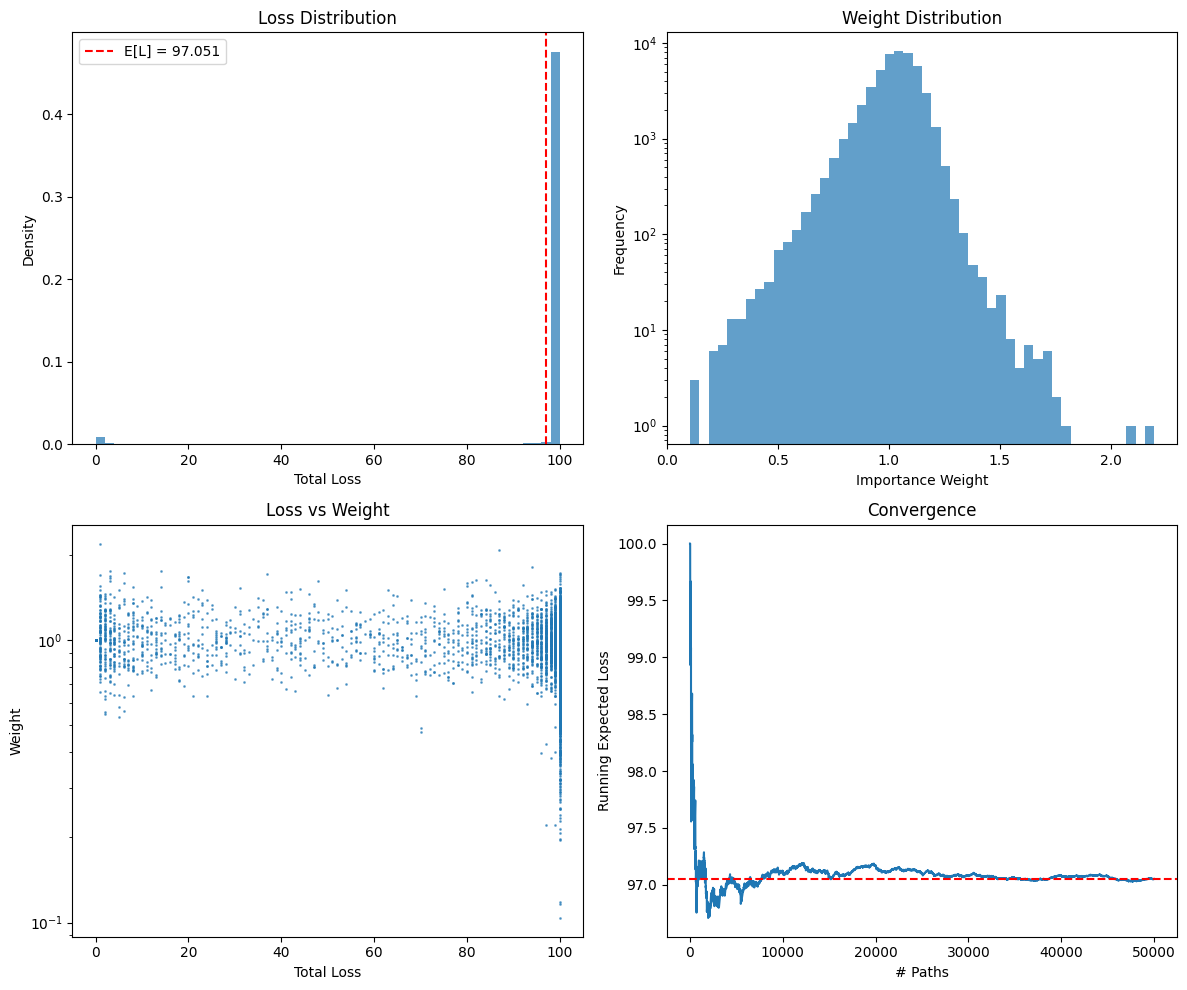


Simulation Results:
Expected Loss: 97.051202
Standard Error: 0.070229
95% CI: [96.913553, 97.188850]
Effective Sample Size: 49281.7
Weight Statistics: min=1.04e-01, max=2.20e+00, mean=1.02e+00


In [7]:
params = draw_params(N=100, J=3, seed=42)
simulator = MonteCarloSimulator(params)

results = simulator.run_simulation(n_paths=50000, T=1.0, dt_max=0.001, base_seed=42)
simulator.plot_results(results)
simulator.plot_sample_intensity_paths(T=1.0, dt_max=0.001, n_paths=1, seed=42)